## Decoder-only architecture - GPT2

## 1. Introduction

For this lab, we will focus on **decoder-only models**, particularly **GPT-2** (Generative Pre-trained Transformer 2), a model designed for text generation.

#### **Decoder-Only Models**
Decoder-only models, like GPT-2, differ from encoder-decoder models in that they generate text in a **unidirectional (left-to-right)** manner. These models do not have an encoder to process the entire input at once. Instead, they use **autoregressive** generation, predicting the next token based on the preceding context.

For the part of this lab, we will use `GPT2LMHeadModel`, a GPT-2 model with a language modeling head.

In [33]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 tokenizer and model
model_name = 'gpt2'  
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### 1. **Embeddings Layer**
The embeddings layer creates initial representations of the input tokens, encoding both the meaning of the words and their positions within the sequence.

- **Word Embeddings** (`wte`): Maps each of the 50,257 vocabulary tokens into a 768-dimensional vector space.
- **Position Embeddings** (`wpe`): Adds positional information to the tokens using a learned embedding of size 1024 (representing the maximum sequence length) with 768 dimensions. This allows the model to understand the order of the tokens, as transformers do not have an inherent sense of position.

### 2. **Transformer Block (Decoder)**
The core of GPT-2 is composed of 12 identical **transformer blocks**, each consisting of several sub-components. These blocks are stacked to process the input text in a sequential, autoregressive manner.

Each transformer block includes the following:

- **Layer Normalization (ln_1, ln_2)**: Normalization is applied before both the attention mechanism and the feed-forward network to stabilize and speed up training. It ensures that the inputs to the layers have zero mean and unit variance, using learned parameters.

- **Self-Attention Mechanism**

  - **Self-Attention Mechanism (attn)**: GPT-2 uses masked self-attention to ensure that the model can only attend to tokens that have already been processed, preventing the model from "seeing" future tokens. This makes the model autoregressive.
    
    - **Query, Key, Value Projections**: The attention mechanism computes the **query (Q)**, **key (K)**, and **value (V)** vectors using **Conv1D layers** (`c_attn`).

    - **Attention Output**: The output of the attention layer is passed through another **Conv1D layer** (`c_proj`) to project it back to the original 768-dimensional space.

- **Feed-Forward Neural Network (mlp)**
Each transformer block also contains a fully connected feed-forward neural network that processes the output of the attention mechanism. This is done in two stages:

  - **First Linear Transformation (`c_fc`)**: Expands the dimensionality from 768 to a larger intermediate size using a **Conv1D layer**.
    
  - **Activation Function (`act`)**: Applies the **GELU (Gaussian Error Linear Unit)** activation function, which introduces non-linearity and helps the model capture complex patterns in the data.

  - **Second Linear Transformation (`c_proj`)**: Projects the output back down from the intermediate size to 768 dimensions using another **Conv1D layer**.

- **Residual Connections**
  - GPT-2 uses skip connections around both the self-attention and feed-forward layers, where the input to each sub-layer is added to its output.

### 3. **Final Layer Normalization and Language Modeling Head**
- After passing through all 12 transformer blocks, a final **LayerNorm** (`ln_f`) is applied to normalize the output before it is passed to the language modeling head for token prediction.

- The output of the final transformer block is passed through a **linear layer** (`lm_head`) which maps the 768-dimensional hidden states to the vocabulary size (50,257). This step is essential for converting the hidden representations into predictions for the next token in the sequence.


In [34]:
# Set the model to evaluation mode
model.eval()

# Define the input prompt
prompt = "I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair."

# Tokenize the input prompt
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# Autoregressively generate tokens 
generated_ids = model.generate(input_ids, max_length=200, do_sample=True, temperature=1.1)

# Decode and print the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generated Text:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair. He asked him several questions that I could not understand. 'When did you get started in a new position?' he asked them for a second time. 'When did you come home?' asked the young gentleman. 'Why not?' asked it again for another thirty minutes, then resumed his examination as it had been asked before. 'No need,' said he, nodding his head in no small amount of surprise. 'I was working in the London Stock Exchange at the time of your father's death. I came home after the funeral with the orders to call your dear father, and that was almost all that was asked of me in return. I would have told you, however, if you had let me. If you were a good one that you came into your present circumstances,


## 2. Decoder (Masked) Self-Attention Mechanism

In this exercise, we will focus on the **masked self-attention mechanism** used in the decoder blocks of GPT-2. This mechanism allows the model to attend to previous tokens in an autoregressive manner, ensuring that the model generates text sequentially from left to right without looking ahead to future tokens.

A plot of the **self-attention matrix** for a single decoder block in GPT-2 is shown below. The matrix represents the attention weights between different tokens in the input sequence. The **x-axis** and **y-axis** correspond to the tokens in the input sequence. Each position on these axes represents a specific token in the input text.
  
#### **Masked Self-Attention Behavior:**
- As expected in a **decoder-only** model, we observe a clear triangular pattern. Tokens only attend to themselves and the tokens that precede them. For example, the first token (`I`) only attends to itself, the second token (`love`) attends to both itself and the first token, and so on.
- The upper-right part of the matrix is empty (dark purple), indicating that the model **masks future tokens** to prevent them from being used in generating the current token. This ensures that GPT-2 maintains its **autoregressive property**, where each token is generated based only on past tokens.

- In the image, you can see that certain tokens attend more strongly to previous tokens. For example, the token `favorite` attends heavily to earlier tokens like `Italian` and `food`, as indicated by the brighter colors in the heatmap.
- The model tends to attend more to the recent past tokens, which is crucial for maintaining context during text generation.


/home/csavelli/.conda/envs/claudio/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


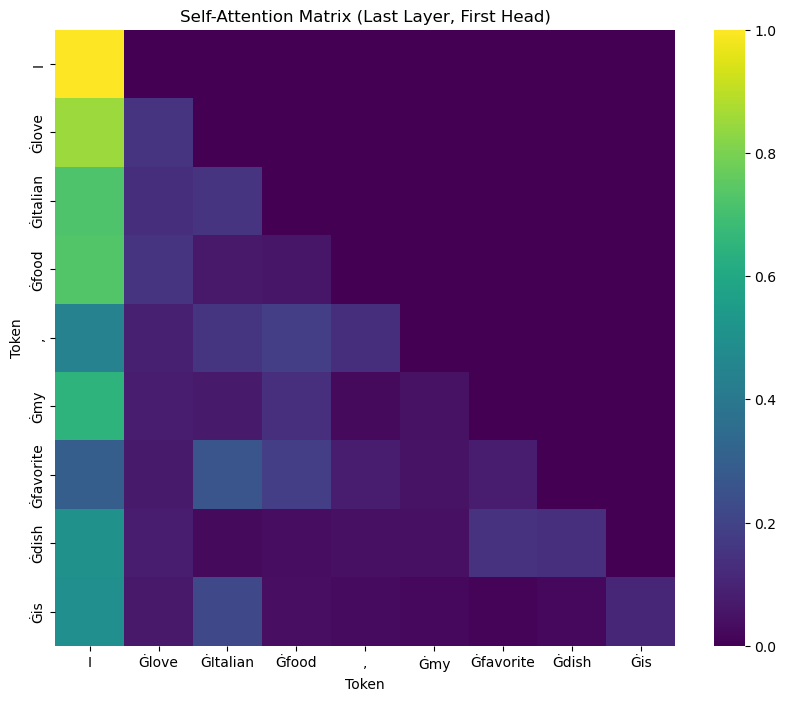

In [45]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns

model_name = 'gpt2'  # Assicurati di avere il nome del modello corretto
model = GPT2Model.from_pretrained(model_name, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Input prompt
prompt = "I love Italian food, my favorite dish is"

# Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt')

# Generate the model output and retrieve attention weights
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of attention matrices from all layers

# Visualize the attention weights from the last layer
attention_matrix = attentions[-1][0][10].cpu().numpy()  # Last layer, first head

# Get the tokens for the input prompt
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Plot the attention matrix (last layer, first head) with words as labels
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title('Self-Attention Matrix (Last Layer, Tenth Head)')
plt.xlabel('Token')
plt.ylabel('Token')
plt.show()

## 3. Positional Embedding

Similarly to what we have seen in the previous exercise (`01-bert`), GPT-2 uses **positional embeddings** to encode the position of tokens in the input sequence. These embeddings are added to the token embeddings to provide the model with information about the order of the tokens. 

Also in GPT-2, the positional embeddings are learned during training, allowing the model to capture complex patterns in the data.

In [49]:
model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

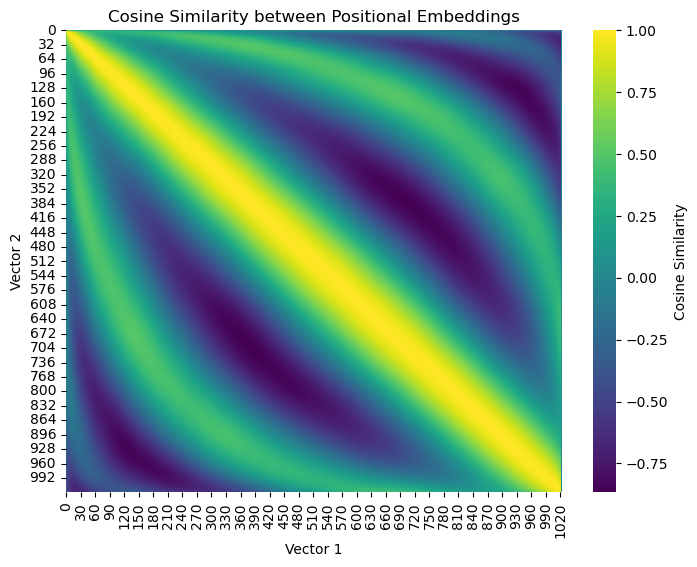

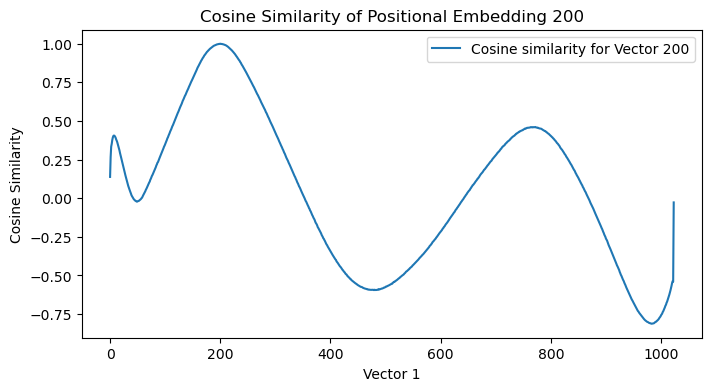

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Extract learned positional embeddings from the model
positional_embeddings = model.wpe.weight.detach().cpu().numpy()  # Shape: (1024, 768)

# Compute cosine similarity between positional embeddings
cosine_sim = cosine_similarity(positional_embeddings)

# Plot cosine similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim, cmap='viridis')
plt.title('Cosine Similarity between Positional Embeddings')
plt.xlabel('Vector 1')
plt.ylabel('Vector 2')
plt.show()

# Plot cosine similarity for positional embedding 200
plt.figure(figsize=(8, 4))
plt.plot(cosine_sim[200], label='Cosine similarity for Vector 200')
plt.xlabel('Vector 1')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity of Positional Embedding 200')
plt.legend()
plt.show()

## 4. Sampling Methods

## 5. Fine-Tuning and Inference